در این پروژه می‌خواهیم به کمک کتابخانه تنسورفلو و رابط سطح بالای کراس به طبقه‌بندی تصاویر بپردازیم. برای این کار، چند کتابخانه وارد فضای کاری کرده و دیتاست داده‌شده را از حالت فشرده خارج می‌کنیم

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
import os
import re

# پیش‌پردازش

In [ ]:
!tar -xvf  '/content/drive/MyDrive/UTKFace.tar.gz' -C '/content/'

پس از خارج کردن دیتاست تصاویر از حالت فشرده، به بررسی آن‌ها پرداخته و تصاویر مخدوش را حذف می‌کنیم. این کار یکی از کارهای متداول برای پیش‌پردازش دیتاست تصاویر است. در این دیتاست تصویر مخدوشی وجود نداشت. بنابراین هیچ تصویری حذف نشد

In [4]:
folder_path = '/content/UTKFace'
num_skipped = 0
for fname in os.listdir(folder_path):
  fpath = os.path.join(folder_path, fname)
  try:
    fobj = open(fpath, "rb")
    is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
  finally:
    fobj.close()
  if not is_jfif:
    num_skipped += 1
    os.remove(fpath)
print(f"Deleted {num_skipped} images")

Deleted 0 images


در این مرحله، تصاویر را به ۵ کلاس صفر تا چهار تقسیم‌بندی می‌کنیم. این کار را برای این انجام می‌دهیم که بتوانیم از رابط کراس استفاده کنیم تا تصاویر را در هنگام بارگذاری، سیاه‌سفید کرده و به اندازه گفته شده یعنی ۱۰۰ در ۱۰۰ درآوریم. متد استفاده شده از رابط کراس، آدرس پوشه را گرفته و پوشه‌های داخل آن را به عنوان کلاس در نظر می‌گیرد. بنابراین، با توجه به اسم هر تصویر، آن را در یکی از پوشه‌های صفر تا چهار قرار می‌دهیم

In [5]:
for i in range(5):
  fpath = os.path.join(folder_path, str(i))
  os.makedirs(fpath)
prog = re.compile('_(\d)')
for fname in os.listdir(folder_path):
  imgpath = os.path.join(folder_path, fname)
  if os.path.isfile(imgpath):
    result = prog.findall(fname)
    fpath = os.path.join(folder_path, result[1])
    new_imgpath = os.path.join(fpath, fname)
    os.rename(imgpath, new_imgpath)

حالا که تصاویر را در پوشه‌های گفته شده قرار داده‌ایم، باید دیتاست آموزش و تست را به نسبت ۷ به ۳ از روی تصاویر ساخته و اندازه تصاویر را ۱۰۰ در ۱۰۰ در نظر گرفته و کانال رنگی آن‌ها را حذف کنیم

In [6]:
train_ds = keras.preprocessing.image_dataset_from_directory(
  folder_path, labels='inferred', label_mode='categorical',
  color_mode='grayscale', batch_size=32, image_size=(100, 100),
  shuffle=True, seed=1400, validation_split=0.3, subset='training'
)
test_ds = keras.preprocessing.image_dataset_from_directory(
  folder_path, labels='inferred', label_mode='categorical',
  color_mode='grayscale', batch_size=32, image_size=(100, 100),
  shuffle=True, seed=1400, validation_split=0.3, subset='validation'
)

Found 23708 files belonging to 5 classes.
Using 16596 files for training.
Found 23708 files belonging to 5 classes.
Using 7112 files for validation.


در این مرحله، تصاویر آموزش را در متغیر ایکس ترین و کلاس وان‌هات شده آن‌ها را متغیر وای تریم قرار می‌دهیم. تعداد تصاویر هر کلاس را به دست آورده و نمودار میله‌ای آن‌ها را رسم می‌کنیم. دقت شود که اگر کلاس تصاویر به شکل وان‌هات انکود نمی‌شد، ممکن بود شبکه در مفهوم اعداد متوالی به اشتباه بیفتد و گمان کند که کلاس با عدد بزرگ‌تر، ارزش‌مندتر از کلاس با عدد کم‌تر است. در حالی که این گونه نیست. استفاده از برچسب‌های عددی برای مشخص کردن کلاس‌ها، در مسائلی کاربرد دارد که تفاوت برچسب هر کلاس با دیگری، معنادار است. به عنوان مثال، در مسائل طبقه‌بندی وزن یا قد، که ترتیب حائز اهمیت است، از برچسب‌گذاری استفاده می‌کنیم

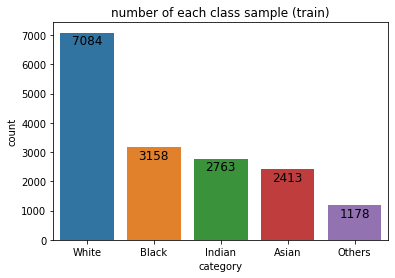

In [7]:
first_batch = True
for batch in train_ds:
  if first_batch:
    x_train = batch[0].numpy()
    y_train = batch[1].numpy()
    first_batch = False
  else:
    x_train = np.concatenate((x_train, batch[0].numpy()))
    y_train = np.concatenate((y_train, batch[1].numpy()))
(unique, counts) = np.unique(y_train, return_counts=True, axis=0)
unique = list(map(lambda x: np.argmax(x), unique))
counts = list(map(lambda x: x, counts))
categories = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}
categories = list(map(lambda x: categories[x], unique))
df = pd.DataFrame({'category': categories,
                   'count': counts})
barplot = sns.barplot(x='category',
                      y='count',
                      data=df,
                      order=df.sort_values('count', ascending=False).category)
title = plt.title('number of each class sample (train)')
for p in barplot.patches:
  barplot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   size=12,
                   xytext=(0, -8),
                   textcoords='offset points')

کارهای گفته شده پیش از سلول قبل را برای داده‌های تست هم انجام می‌دهیم

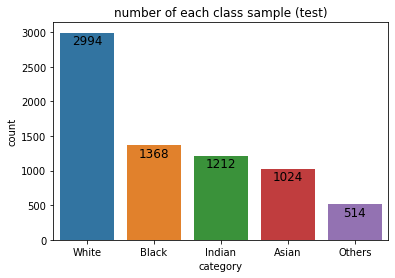

In [8]:
first_batch = True
for batch in test_ds:
  if first_batch:
    x_test = batch[0].numpy()
    y_test = batch[1].numpy()
    first_batch = False
  else:
    x_test = np.concatenate((x_test, batch[0].numpy()))
    y_test = np.concatenate((y_test, batch[1].numpy()))
(unique, counts) = np.unique(y_test, return_counts=True, axis=0)
unique = list(map(lambda x: np.argmax(x), unique))
counts = list(map(lambda x: x, counts))
categories = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}
categories = list(map(lambda x: categories[x], unique))
df = pd.DataFrame({'category': categories,
                   'count': counts})
barplot = sns.barplot(x='category',
                      y='count',
                      data=df,
                      order=df.sort_values('count', ascending=False).category)
title = plt.title('number of each class sample (test)')
for p in barplot.patches:
  barplot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   size=12,
                   xytext=(0, -8),
                   textcoords = 'offset points')

مشاهده می‌شود که تعداد تصاویر دیتاست برای کلاس سفیدپوستان، بیش‌تر از سایر تصاویر است. هم‌چنین، کلاس «سایر» دارای کم‌ترین تعداد تصاویر است

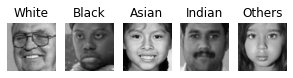

In [9]:
categories = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}
plt.figure(figsize=(5, 5))
j = 0
for image, label in zip(x_train, y_train):
  label = np.argmax(label)
  if label == j:
    ax = plt.subplot(1, 5, j + 1)
    plt.imshow(image.reshape(100, 100).astype("uint8"), cmap='gray')
    plt.title(categories[label])
    plt.axis("off")
    j += 1
  elif j > 4:
    break

همان‌طور که مشاهده می‌شود، ۵ تصویر نمونه از هر کلاس رسم شده تا نشان دهد که هر کلاس دارای چه تصاویری است. در این مرحله، باید تصاویر را نرمال کنیم. این کار برای این انجام می‌شود که آموزش شبکه به درستی انجام شود. به این منظور، تمام درایه‌های ماتریس تصاویر را بر ۲۵۵ تقسیم می‌کنیم. هم‌چنین، هر تصویر را از بعد ۲ به بعد ۱ درمی‌آوریم

In [10]:
x_train = x_train.reshape((x_train.shape[0], 100 * 100 * 1))
x_test = x_test.reshape((x_test.shape[0], 100 * 100 * 1))
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# آموزش

در این مرحله، شبکه‌ای چهار لایه، با دو لایه میانی طراحی می‌کنیم. تعداد نورون‌های ورودی، ۱۰۰۰۰ است و تعداد نورون‌های خروجی، ۵. تابع فعال‌ساز همه لایه‌ها به جز لایه آخر که سافت‌مکس است، رلو بوده و تعداد نورون‌های لایه‌های میانی به ترتیب ۳۲ و ۱۰۲۴ است. بهینه‌ساز را استوکستیک گردینت دیسنت در نظر می‌گیریم و نرخ یادگیری را همان طور که گفته شده، برابر ۰.۰۱. تابع خطا را نیز کراس آنتروپی مخصوص دسته‌بندی قرار می‌دهیم که راجع به آن در ادامه توضیح داده می‌شود <br>
با مشاهده نمودار خطا بر حسب ایپاک روی داده آموزش، می‌بینیم که خطا با شیب کمی کاهش یافته، با این وجود، در نمودار خطا بر حسب ایپاک روی داده تست، خطا کم و زیاد شده و درگیر نویز است. برای رفع این مشکل، می‌توان مدل را رگوله کرد. از روش‌های رگوله کردن مدل می‌توان به افزایش تعداد داده آموزش (یا تولید داده مصنوعی)، بهبود روش نرمال کردن داده، کاهش نرخ یادگیری (زیرا اگر نرخ یادگیری بزرگ باشد، بهینه‌ساز از روی کمینه محلی عبور می‌کند و نمی‌تواند وارد آن شود)، افزایش نرخ یادگیری (با بیش از حد کوچک بودن نرخ یادگیری، روی نمودار خطا نویز ایجاد می‌شود)، استفاده از توابع بهینه‌ساز دیگر مانند آدام، استفاده از لایه‌های رگوله‌سازی مانند ال-۲ و دراپ‌اوت و یا به کار گیری روش‌های توقف زودهنگام اشاره کرد

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 32)                320032    
_________________________________________________________________
dense_140 (Dense)            (None, 1024)              33792     
_________________________________________________________________
dense_141 (Dense)            (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________
              precision    recall  f1-score   support

       White       0.72      0.87      0.79      7084
       Black       0.70      0.85      0.77      3158
       Asian       0.78      0.65      0.71      2413
      Indian       0.70      0.53      0.61      2763
      Others       0.42      0.02      0.04      1178

    accuracy                           0.72     165

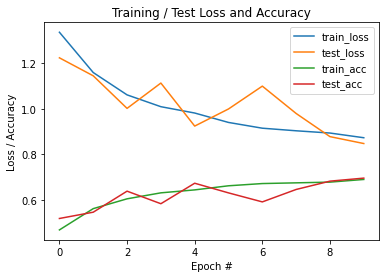

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(0.01), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 10), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 10), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 10), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 10), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

همان طور که مشاهده می‌شود، مقدار «صحت» برای ۴ کلاس اول، روی داده تست و آموزش تقریباً یکسان است. با این وجود، مقدار «صحت» کلاس «سایر» روی داده آموزش برابر ۳۳ درصد و روی داده تست برابر ۰ است. میانگین حسابی مقادیر «صحت» نیز روی داده آموزش ۶۳ درصد و روی داده تست ۵۵ درصد است. این به آن معناست که برای کلاس «سایر»، تقریباً هیچ نمونه‌ای درست تشخیص داده نشده. در حالی که تعدادی از نمونه‌ها به اشتباه در این کلاس طبقه‌بندی شده‌اند <br>
راجع به مقادیر «بازیابی» نیز می‌توان گفت که عملکرد شبکه برای تشخیص نژادهای سفید، سیاه، چینی و هندی قابل‌قبول بوده، با این وجود تقریباً نتوانسته هیچ کدام از تصاویر را به درستی در کلاس «سایر» جای دهد. برای درک این موضوع، می‌توان فرض کرد که شبکه، تنها ۲ چهره را به درستی در کلاس «سایر» قرار داده، ۴ چهره را نیز به اشتباه در این کلاس طبقه‌بندی کرده، و بنابراین، مقدار «صحت» این کلاس، برابر ۳۳ درصد شده و مقدار «بازیابی» آن، برابر نسبت ۲ به ۱۱۷۸ که تقریباً برابر صفر است. دلیل این موضوع می‌تواند کم بودن تعداد داده‌های آموزش برای این کلاس باشد. یکی از راه‌های رفع مشکل، مقیاس‌بندی داده‌های آموزش است. یعنی برابر ساختن تعداد داده‌های هر کلاس. برای این کار، می‌توان تعدادی داده مصنوعی به کمک داده‌های حاضر برای کلاس «سایر» تولید کرد. پیش‌بینی می‌شود که با این کار، قدرت تشخیص شبکه برای این کلاس، بالاتر رود

# قسمت اول) تأثیر بهینه‌ساز

در این بخش، می‌خواهیم بدانیم که تأثیر تابع بهینه‌ساز روی فرایند آموزش مدل به چه صورت است. به این منظور، مفهوم ممان را معرفی می‌کنیم. می‌دانیم که در حالت عادی، بهینه‌ساز استفاده شده، در هر مرحله آموزش دسته‌ها، حاصل‌ضرب نرخ یادگیری در مشتق تابع خطا نسبت به وزن را از وزن قبلی کم کرده و برابر وزن جدید قرار می‌دهد. در صورتی که بخواهیم از ممان استفاده کنیم، رابطه به روز رسانی برابر خواهد شد با
<br>
velocity = momentum * velocity - learning_rate * g
<br>
w = w + velocity
<br>
که در آن، سرعت برابر است با تغییرات وزن در مرحله پیش و جی نیز همان مشتق تابع خطا نسبت به وزن است. مشخص است که اگر ممان صفر باشد، رابطه به روز رسانی عادی به دست می‌آید. هر چه ممان به ۱ نزدیک شود، الگوی به روز رسانی مرحله پیش بیش‌تر رعایت خواهد شد و هر چه به صفر نزدیک شود، کم‌تر. اگر تغییرات هم‌جهت باشد، «اثر شتاب‌دهی» ایجاد می‌شود. یعنی آموزش تسریع می‌شود. در غیر این صورت، «اثر پایداری» ظاهر می‌شود و باعث می‌شود که وزن تغییر چندانی نکند. به همین دلیل، یکی از روش‌های از بین بردن پرش‌های نمودار خطا روی داده تست، استفاده از ممان است. دقت شود که با افزایش تعداد ایتریشن‌ها، تأثیر ممان کاهش یافته و به این ترتیب از مقدار بهینه برای وزن، کم‌تر فاصله خواهیم گرفت

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_35 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________
              precision    recall  f1-score   support

       White       0.79      0.77      0.78      7084
       Black       0.66      0.87      0.75      3158
       Asian       0.70      0.78      0.73      2413
      Indian       0.64      0.62      0.63      2763
      Others       0.40      0.04      0.08      1178

    accuracy                           0.72     165

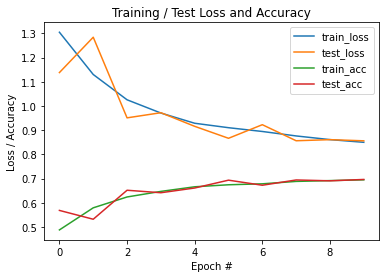

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(0.01, 0.5), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 10), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 10), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 10), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 10), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

مشاهده می‌شود که با در نظر گرفتن ممان برابر با ۰.۵، دقت مدل افزایش چندانی نیافت، با این وجود، مشخص است که نمودار خطا بر حسب ایپاک برای داده تست، پرش‌های کم‌تری دارد. یعنی با افزایش تعداد ایپاک‌ها، استفاده از ممان، امکان رسیدن به دقت بهتر را فراهم می‌کند. راجع به تعداد پارامترهای مدل هم می‌توان گفت که از آن جا که ورودی مدل بردار ۱۰۰۰۰ تایی بوده و تعداد نورون‌های لایه مخفی اول، ۳۲ تاست، با حساب کردن ۳۲ مقدار بایاس، ۳۲۰۰۳۲ پارامتر خواهیم داشت. هم‌چنین، ۳۲ در ۱۰۲۴ به علاوه ۱۰۲۴ برابر است با ۳۳۷۹۲ که تعداد پارامترهای لایه بعد را نشان می‌دهد. تعداد پارامترهای لایه آخر هم برابر است با حاصل‌ضرب ۵ در ۱۰۲۴ به علاوه ۵. پس در مجموع، ۳۵۸۹۴۹ پارامتر برای آموزش خواهیم داشت

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       White       0.43      1.00      0.60      7084
       Black       0.00      0.00      0.00      3158
       Asian       0.00      0.00      0.00      2413
      Indian       0.00      0.00      0.00      2763
      Others       0.00      0.00      0.00      1178

    accuracy                           0.43     16596
   macro avg       0.09      0.20      0.12     16596
weighted avg       0.18      0.43      0.26     16596

              precision    recall  f1-score   support

       White       0.42      1.00      0.59      2994
       Black       0.00      0.00      0.00      1368
       Asian       0.00      0.00      0.00      1024
      Indian       0.00      0.00      0.00      1212
      Others       0.00      0.00      0.00       514

    accuracy                           0.42      7112
   macro avg       0.08      0.20      0.12      7112
weighted avg       0.18      0.42      0.25      7112



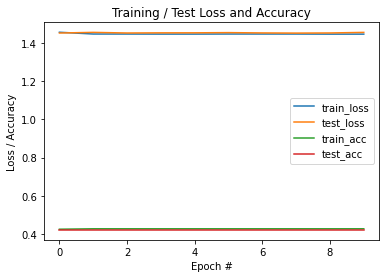

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(0.01, 0.9), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 10), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 10), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 10), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 10), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

مشاهده می‌شود که با در نظر گرفتن ممان برابر با ۰.۹ آموزش صورت نگرفته و مقدار دقت تغییری نکرده. دلیل این موضوع این است که شبکه بیش از حد تحت تأثیر آموزش قبلی بوده و هر چه قدر که گرادیان تابع خطا افزایش یابد، نمی‌تواند بر تأثیر آموزش قبل غلبه کند. بنابراین، واضح است که افزایش ممان همواره سودآور نبوده و می‌تواند آموزش را مختل کند

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_44 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________
              precision    recall  f1-score   support

       White       0.68      0.90      0.77      7084
       Black       0.81      0.75      0.78      3158
       Asian       0.72      0.72      0.72      2413
      Indian       0.72      0.48      0.57      2763
      Others       0.33      0.00      0.00      1178

    accuracy                           0.71     165

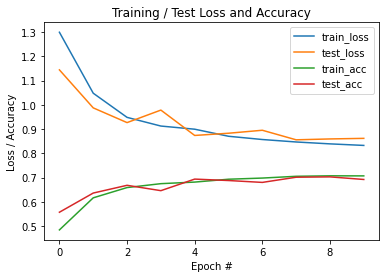

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 10), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 10), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 10), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 10), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_47 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_48 (Dense)             (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       White       0.43      1.00      0.60      7084
       Black       0.00      0.00      0.00      3158
       Asian       0.00      0.00      0.00      2413
      Indian       0.00      0.00      0.00      2763
      Others       0.00      0.00      0.00      1178

    accuracy                           0.43     16596
   macro avg       0.09      0.20      0.12     16596
weighted avg       0.18      0.43      0.26     16596

              precision    recall  f1-score   support

       White       0.42      1.00      0.59      2994
       Black       0.00      0.00      0.00      1368
       Asian       0.00      0.00      0.00      1024
      Indian       0.00      0.00      0.00      1212
      Others       0.00      0.00      0.00       514

    accuracy                           0.42      7112
   macro avg       0.08      0.20      0.12      7112
weighted avg       0.18      0.42      0.25      7112



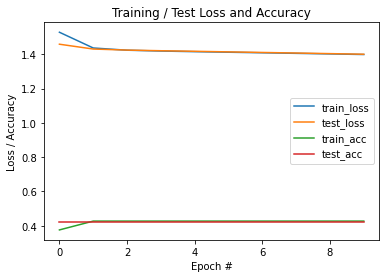

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(0.0001), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 10), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 10), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 10), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 10), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

مشاهده می‌شود که به ازای نرخ یادگیری ۰.۰۰۰۱، آدام بهتر از اس‌جی‌دی عمل می‌کند. دقت شود که آدام با نرخ یادگیری گفته شده عملکرد خوبی نداشت، برای همین تصمیم گرفته شد که از این نرخ یادگیری استفاده شود. دقت شود که استفاده از تابع بهینه‌ساز آدام، پرش‌های نمودار خطای داده تست را نیز کاهش داد. هم‌چنین، استفاده از گرادیان کاهشی و ممان، بهترین نتیجه تا به این جا بوده است. البته با افزایش تعداد ایپاک‌ها، این مدل دچار اورفیت می‌شود



# قسمت دوم) تأثیر تعداد ایپاک‌ها

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_51 (Dense)             (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________
              precision    recall  f1-score   support

       White       0.71      0.88      0.78      7084
       Black       0.81      0.78      0.80      3158
       Asian       0.90      0.49      0.64      2413
      Indian       0.60      0.74      0.66      2763
      Others       0.51      0.02      0.03      1178

    accuracy                           0.72     165

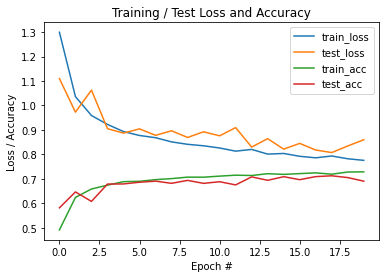

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 20), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 20), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 20), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 20), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

مشاهده می‌شود که دقت مدل روی داده تست و آموزش بالاتر رفت. می‌دانیم که برای آن که شبکه بتواند عملکرد خوبی روی پیش‌بینی کلاس داده تست داشته باشد، باید وزن‌ها و بایاس‌های مناسب را آموزش دیده باشد. برای این کار، لازم است تا چندین بار با داده آموزش تنظیم شود. معمولا این فرایند بیش از یک بار طول می‌کشد. زیرا با یک بار اجرای آن، گرادیان کاهشی نمی‌تواند اکسترمم بهینه را پیدا کند. مگر آن که وزن‌های اولیه به شکل تصادفی بهینه باشند که احتمال آن کم است. پس به طور کلی شبکه باید چندین بار داده آموزش را ببیند تا بتواند قدرت کلاس بندی داده‌ای که ندیده را پیدا کند. معمولا این کار را به تعدادی انجام می‌دهیم که اورفیت آغاز شود. یعنی علی رغم بهینه شدن عملکرد شبکه روی داده آموزش، خطای داده تست بالا رود. البته این داده را به طور کلی، داده اعتبار سنجی می‌نامند که در برخی مدل‌ها، به کمک آن می‌توان تعداد ایپاک‌ها را در هنگام آموزش کنترل کرد. پس می‌توان گفت که همواره افزایش ایپاک‌ها مفید نیست و می‌تواند باعث تضعیف قدرت شبکه شود. راهی که برای جلوگیری از افزایش واریانس و وقوع پدیده اورفیت پیشنهاد می‌شود، همان است که پیش‌تر ذکر شد. یعنی استفاده از داده اعتبارسنجی و توقف آموزش در صورتی که پس از تعداد مشخصی ایپاک، دقت داده اعتبارسنجی مخالف دقت داده آموزش تغییر کرد. البته می‌توان با در نظر گرفتن یک ترشولد نیز این کار را انجام داد. به این صورت که پس از گذشتن تعدادی ایپاک، اگر دقت داده آموزش از ترشولد بیش‌تر تغییر نکرد، آموزش متوقف شود. زیرا ممکن است از جایی به بعد، آموزشی صورت نگیرد

# قسمت سوم) تأثیر تابع هزینه


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_65 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_66 (Dense)             (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________
              precision    recall  f1-score   support

       White       0.77      0.83      0.80      7084
       Black       0.73      0.84      0.78      3158
       Asian       0.86      0.65      0.74      2413
      Indian       0.59      0.74      0.66      2763
      Others       0.51      0.04      0.07      1178

    accuracy                           0.73     165

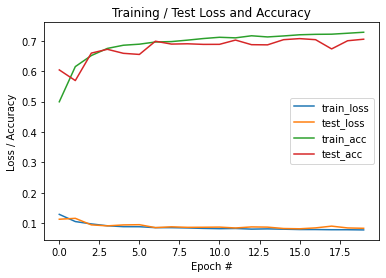

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='mse', optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 20), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 20), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 20), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 20), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

همان طور که مشاهده می‌شود، استفاده از تابع هزینه ذکر شده برای این مدل، عملکرد را بهبود داد. البته به طور کلی می‌دانیم که در مسائل رگرسیون از این تابع هزینه استفاده می‌شود زیرا فاصله بین مقادیر خروجی کم است و نیاز است که سرعت همگرایی کندتر باشد. در صورتی که سرعت همگرایی زیاد شود (مثلا از تابع هزینه کراس انتروپی استفاده کنیم) ممکن است که همگرایی انجام نشود و مدل به کمینه‌های محلی نرسد. از تابع هزینه کراس انتروپی هم برای مسائل طبقه‌بندی استفاده می‌شود. زیرا شیب نمودار لگاریتم تندتر بوده و همگرایی در این مسائل (که هر نمونه متعلق به یک کلاس است) تندتر انجام می‌شود. استفاده از تابع هزینه میانگین مجذور خطا در این مسائل توصیه نمی‌شود زیرا تمرکز را روی تمامی خروجی‌های شبکه قرار می‌دهد. حال آن که باید صرفاً خروجی مربوط به کلاس نمونه بیش‌تر از بقیه باشد و لزومی ندارد که بقیه خروجی‌ها بررسی شوند <br>
دقت شود که پس از استفاده از روش‌های رگوله‌سازی روی هر دو مدل «میانگین مجذور خطا» و «کراس انتروپی»، دقت مدل دوم بهتر شد. بنابراین، در ادامه کار از همان تابع هزینه پیش استفاده می‌کنیم

# قسمت چهارم) تأثیر رگوله‌سازی

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_74 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_75 (Dense)             (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________
              precision    recall  f1-score   support

       White       0.77      0.85      0.81      7084
       Black       0.84      0.78      0.81      3158
       Asian       0.76      0.77      0.76      2413
      Indian       0.67      0.71      0.69      2763
      Others       0.43      0.17      0.24      1178

    accuracy                           0.75     165

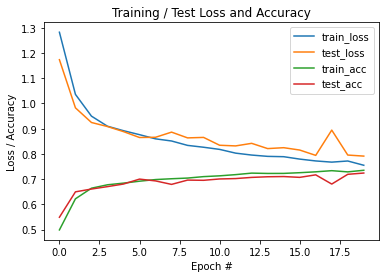

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 20), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 20), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 20), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 20), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

همان طور که مشاهده می‌شود، استفاده از رگوله‌ساز مجذور وزن، باعث شده نمودار خطای داده تست پرش زیادی نداشته باشد و دقت را نیز بهبود داده. استفاده از این روش، یعنی اضافه کردن یک عبارت به تابع هزینه به منظور مجازات پارامترها، باعث جلوگیری آن‌ها از دقیقاً مدل کردن داده آموزش می‌شود و این‌طوری باعث تعمیم مثال‌های جدید می‌شود

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_157 (Dense)            (None, 32)                320032    
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_158 (Dense)            (None, 1024)              33792     
_________________________________________________________________
dense_159 (Dense)            (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________
              precision    recall  f1-score   support

       White       0.76      0.84      0.80      7084
       Black       0.77      0.80      0.79      3158
       Asian       0.75      0.74      0.74      2413
      Indian       0.62     

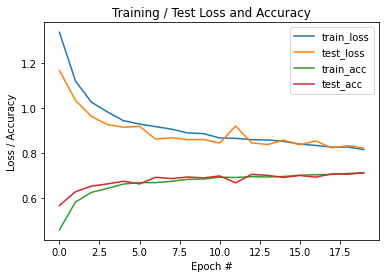

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 20), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 20), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 20), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 20), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

دراپ‌اوت یکی از روش‌های رگوله‌سازی است که استفاده از آن باعث کاهش احتمال وقوع اورفیت می‌شود. با این وجود، ممکن است که در برخی حالات منجر به افزایش واریانس نیز شود. مثلاً استفاده از آن درست پیش از لایه آخر باعث می‌شود که مدل نتواند خطای ایجاد شده توسط لایه دراپ‌اوت را حذف کند و درنتیجه ممکن است که یادگیری درست انجام نشود. اگر که مدل نسبت به دیتاست ساده است، ممکن است که رگوله‌سازی ضروری نباشد. زیرا ظرفیت مدل همین حالا هم پایین است و کم‌تر کردن آن عملکرد را تضعیف می‌کند. در نهایت، اگر زمان آموزش کم باشد، دراپ‌اوت نتیجه معکوس می‌دهد. زیرا مشاهده شده که دراپ‌اوت در ابتدای آموزش باعث کاهش یافتن دقت شده و در هنگام همگرا شدن به دقت نهایی، باعث بهبود عملکرد می‌شود. در این مدل، مشاهده می‌شود که استفاده از روش‌های رگوله‌سازی، همان طور که پیش‌تر هم گفته شد، نمودار خطای داده تست را نرم‌تر کرده و دقت مدل روی داده تست را نیز بهبود داده است

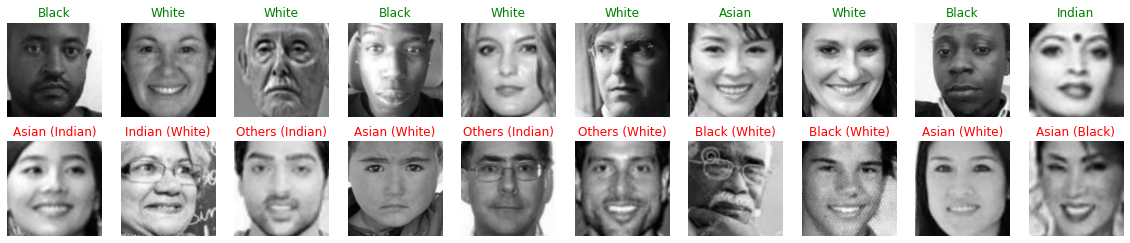

In [ ]:
x_test = x_test.astype('float32') * 255.0
plt.figure(figsize=(20, 4))
correct_pred = 0
wrong_pred = 0
for x, y, y_pred in zip(x_test, y_test, predictions):
  label = np.argmax(y)
  if correct_pred != 10 and label == np.argmax(y_pred):
    ax = plt.subplot(2, 10, correct_pred + 1)
    plt.imshow(x.reshape(100, 100).astype("uint8"), cmap='gray')
    plt.title(categories[label], c='g')
    plt.axis("off")
    correct_pred += 1
  elif correct_pred == 10 and  wrong_pred != 10 and label != np.argmax(y_pred):
    ax = plt.subplot(2, 10, wrong_pred + 11)
    plt.imshow(x.reshape(100, 100).astype("uint8"), cmap='gray')
    plt.title(categories[label] + ' (' + categories[np.argmax(y_pred)] + ')', c='r')
    plt.axis("off")
    wrong_pred += 1
  elif correct_pred == 10 and wrong_pred == 10:
    break